# Rubber stretch
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/solid/rubber_stretch.ipynb)

We load an ISO37 specimen with a Neo-Hookean material.

In [1]:
import matplotlib.pyplot as plt
import torch
from torchfem.examples import get_example_file
from torchfem.io import import_mesh
from torchfem.materials import Hyperelastic3D

torch.set_default_dtype(torch.float64)

# Load per node in top region
F_max = 2.0

# Increments for loading
increments = torch.linspace(0.0, 1.0, 11)

In [2]:
def psi(F, params):
    """Neo-Hookean strain energy density function."""
    # Extract material parameters
    G = params[0]
    D = params[1]
    # Compute right Cauchy-Green tensor
    C = F.transpose(-1, -2) @ F
    # Stable computation of Jacobian
    J = torch.exp(0.5 * torch.logdet(C))
    C_bar = C * J ** (-2.0 / 3.0)
    return G * (torch.trace(C_bar) - 3.0) + 1 / D * (J - 1) ** 2

In [3]:
material = Hyperelastic3D(psi, params=[0.5, 1.0])


# Import mesh
sample = import_mesh(get_example_file("iso37.vtu"), material)


# Define boundary sets
top = sample.nodes[:, 2] >= -16.0
bottom = sample.nodes[:, 2] <= -99.0
back = sample.nodes[:, 1] == 0.0
front = sample.nodes[:, 1] == 4.0

# Apply boundary conditions
sample.constraints[bottom, :] = True
sample.constraints[back, 1] = True
sample.constraints[top, 0] = True
sample.constraints[top, 1] = True
sample.forces[top, 2] = F_max

# Solve
u, f, σ, F, α = sample.solve(
    increments=increments,
    return_intermediate=True,
    nlgeom=True,
)

# Plot results
sample.plot(u=u[-1], element_property={"σ_zz": σ[-1, :, 2, 2]}, show_undeformed=True)

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

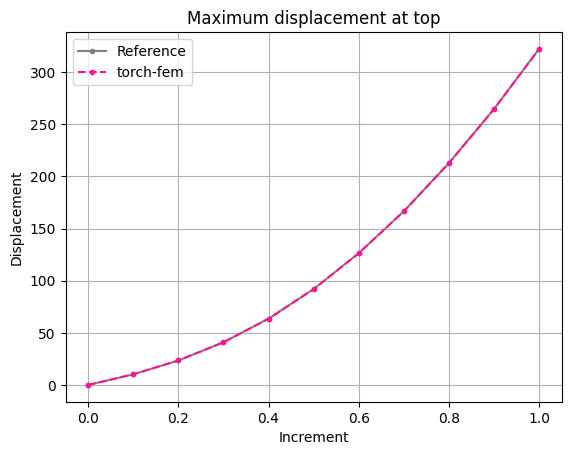

In [4]:
ref_t = torch.linspace(0.0, 1.0, 11)
ref_u = torch.tensor(
    [0.0, 10.16, 23.44, 40.91, 63.55, 91.96, 126.32, 166.61, 212.75, 264.67, 322.31]
)
u_max, _ = u[:, :, 2].detach().max(dim=1)
plt.plot(ref_t, ref_u, ".-", label="Reference", color="gray")
plt.plot(increments, u_max, ".--", label="torch-fem", color="deeppink")
plt.title("Maximum displacement at top")
plt.legend()
plt.xlabel("Increment")
plt.ylabel("Displacement")
plt.grid()
plt.show()